### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
import pickle
from scipy.ndimage.measurements import label
from random import shuffle
from collections import deque

In [2]:
TEST_IMAGE = cv2.imread('./test_images/test1.jpg')
TEST_CUTOUT_IMAGE = './assets/cutout1.jpg'
CARS_LIST = glob.glob('./assets/vehicles/*/*.png')
NOT_CARS_LIST = glob.glob('./assets/non-vehicles/*/*.png')

### Draw Boxes

In [3]:
RANDOM_BBOXES = [((275, 572), (380, 510)), ((488, 563), (549, 518))]
def draw_boxes(img=TEST_IMAGE, bboxes=RANDOM_BBOXES, color=(0, 0, 255), thick=6):
    image = img.copy()
    for a, b in bboxes:
        cv2.rectangle(image, a, b, color, thick)
    return image

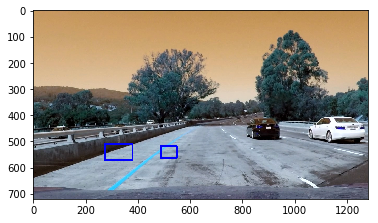

In [4]:
plt.imshow(draw_boxes())
plt.show()

### Template Matching

In [5]:
MATCHING_METHOD = cv2.TM_CCOEFF_NORMED
def find_matches(img=TEST_IMAGE, template_list=[TEST_CUTOUT_IMAGE], method=MATCHING_METHOD):
    bboxes = []
    for file in template_list:
        tmp = mpimg.imread(file) 
        w, h = (tmp.shape[1], tmp.shape[0])
        
        result = cv2.matchTemplate(img, tmp, method)
        
        _, _, _, max_loc = cv2.minMaxLoc(result)
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        bboxes.append((top_left, bottom_right))
    return bboxes


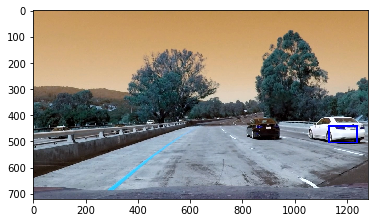

In [6]:
bboxes = find_matches()
plt.imshow(draw_boxes(TEST_IMAGE, bboxes))
plt.show()

### Color Histogram

In [7]:
def color_histogram(img=TEST_CUTOUT_IMAGE, bins=32, bins_range=(0, 256)):
    image = mpimg.imread(TEST_CUTOUT_IMAGE)
    rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))
    
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))

    return rhist, ghist, bhist, bin_centers, hist_features

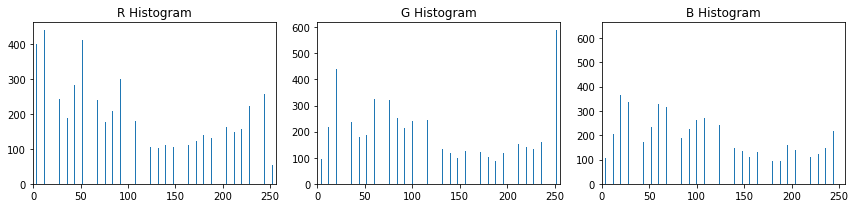

In [8]:
rh, gh, bh, bincen, feature_vec = color_histogram()    
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    plt.show()
else:
    print('Your function is returning None for at least one variable...')

### 3D Color Colorspace

In [9]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):

    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax 


img = cv2.imread(TEST_CUTOUT_IMAGE)

scale = max(img.shape[0], img.shape[1], 64) / 64
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB) 
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  

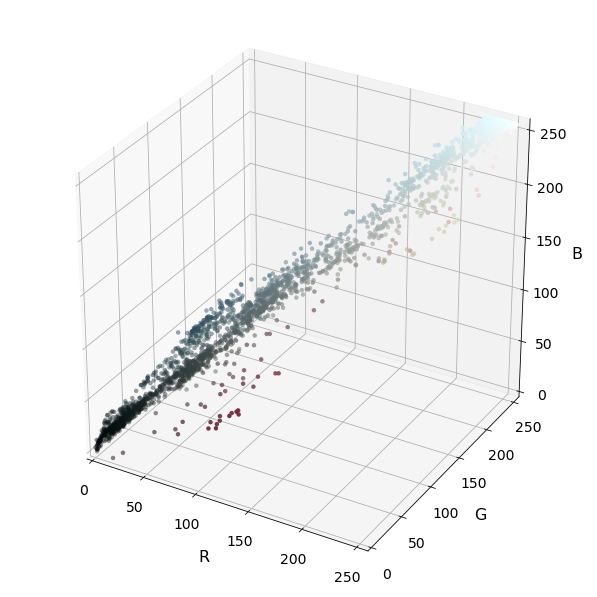

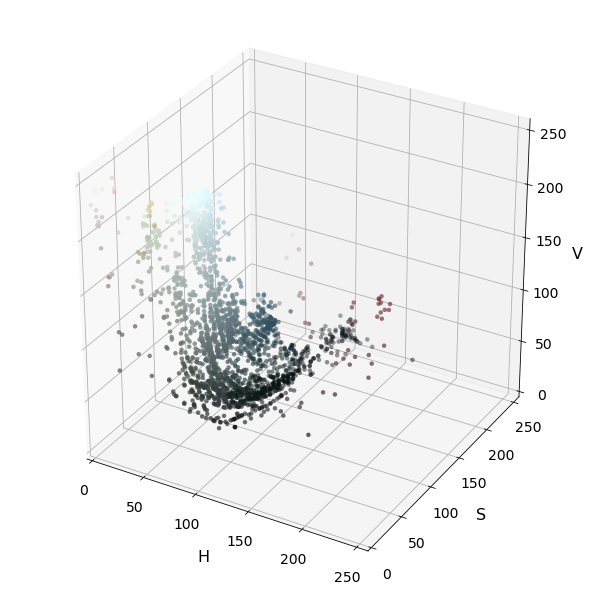

In [10]:
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

### Spatial Binning

In [11]:
def bin_spatial(img, size=(16, 16)):
    dst = cv2.resize(img, size)
    feature_vector = dst.ravel()
    return dst, feature_vector

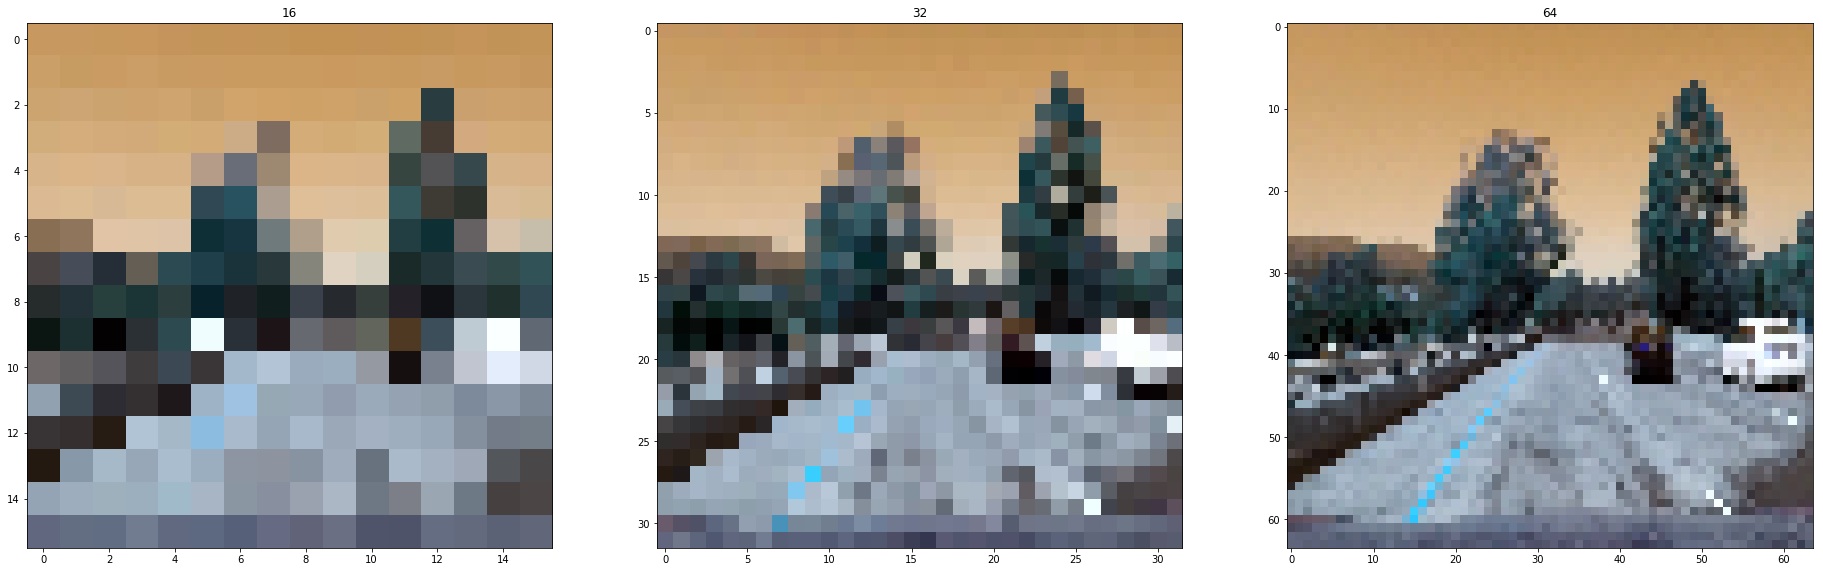

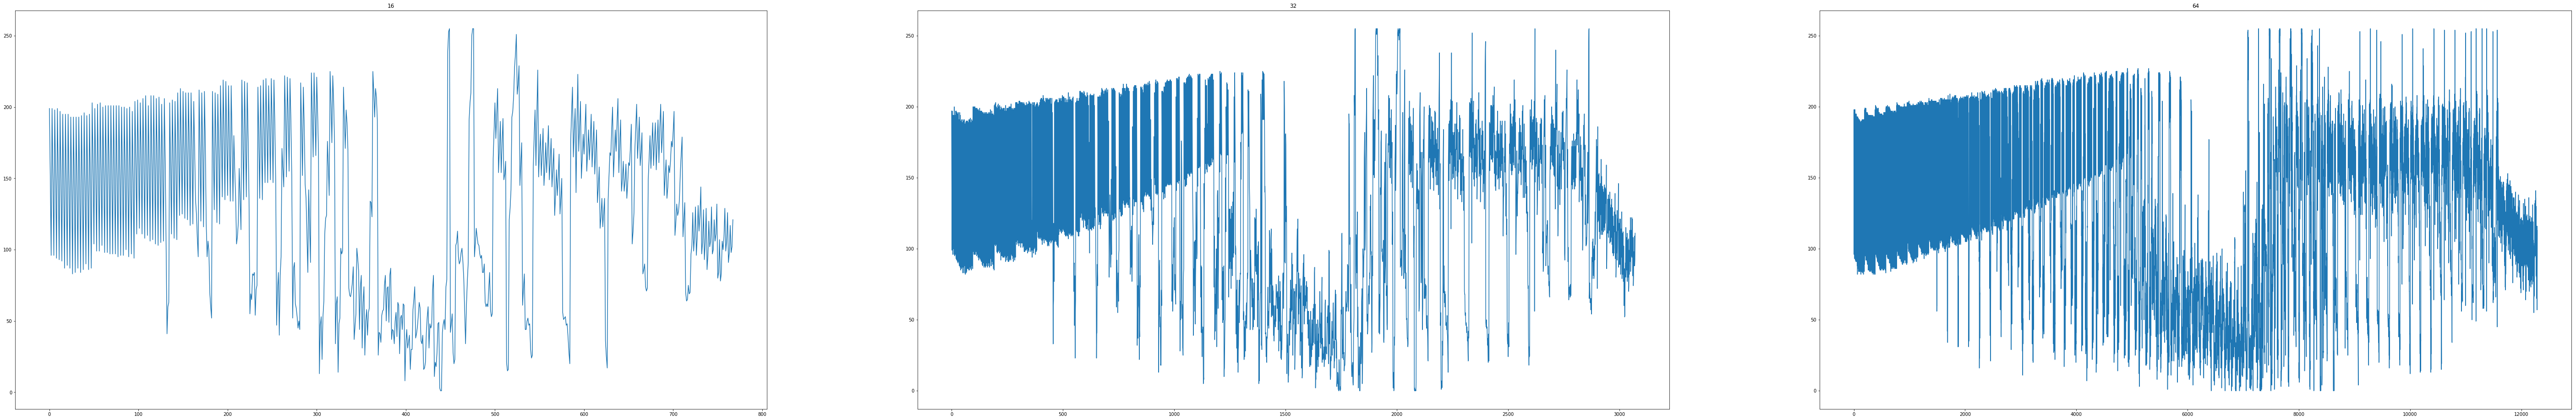

In [12]:
img16, fvector16 = bin_spatial(TEST_IMAGE, (16, 16))
img32, fvector32 = bin_spatial(TEST_IMAGE, (32, 32))
img64, fvector64 = bin_spatial(TEST_IMAGE, (64, 64))

f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(32,32))
ax1.imshow(img16)
ax1.set_title('16')

ax2.imshow(img32)
ax2.set_title('32')

ax3.imshow(img64)
ax3.set_title('64')
plt.show()

f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(100,16))
ax1.plot(fvector16)
ax1.set_title('16')

ax2.plot(fvector32)
ax2.set_title('32')

ax3.plot(fvector64)
ax3.set_title('64')
plt.show()

### Data Lookup

In [13]:
def data_look(car_list=CARS_LIST, notcar_list=NOT_CARS_LIST):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    data_dict["data_type"] = example_img.dtype
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


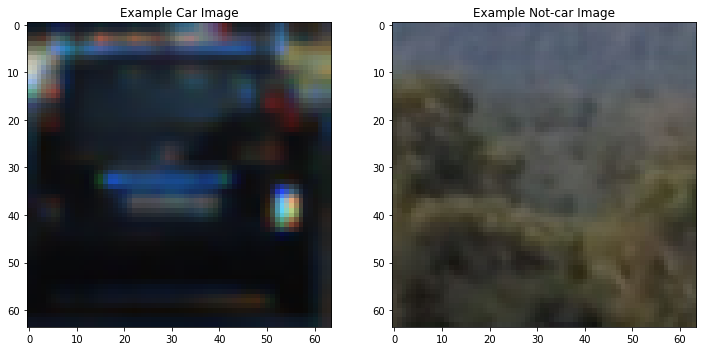

In [14]:
data_info = data_look(CARS_LIST, NOT_CARS_LIST)

print('Your function returned a count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

car_ind = np.random.randint(0, len(CARS_LIST))
notcar_ind = np.random.randint(0, len(NOT_CARS_LIST))
    
car_image = mpimg.imread(CARS_LIST[car_ind])
notcar_image = mpimg.imread(NOT_CARS_LIST[notcar_ind])

fig = plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

### Hog Features

In [15]:
car_ind = np.random.randint(0, len(CARS_LIST))
img = mpimg.imread(CARS_LIST[car_ind])[:,:,0]

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

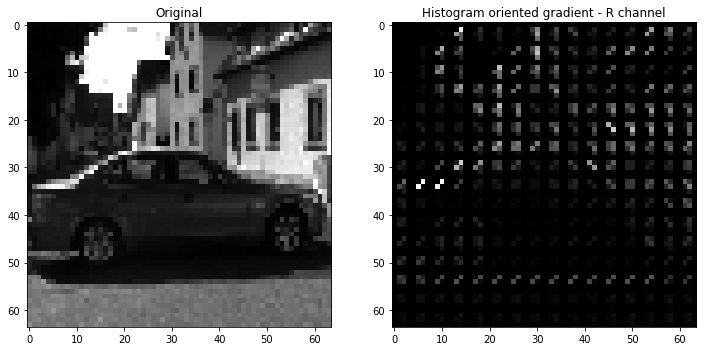

In [16]:
features, hog_image = get_hog_features(img, orient=9, pix_per_cell=4, cell_per_block=2, vis=True)
fig = plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('Histogram oriented gradient - R channel')
plt.show()

### Feature Extraction With Color Histogram and Spatial Binning

In [17]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), hog_channel=2):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        _, spatial_features = bin_spatial(feature_image, size=spatial_size)
        _, _, _, _, hist_features = color_histogram(feature_image, bins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((spatial_features, hist_features)))   
    return features

car_features = extract_features(CARS_LIST)
notcar_features = extract_features(NOT_CARS_LIST)

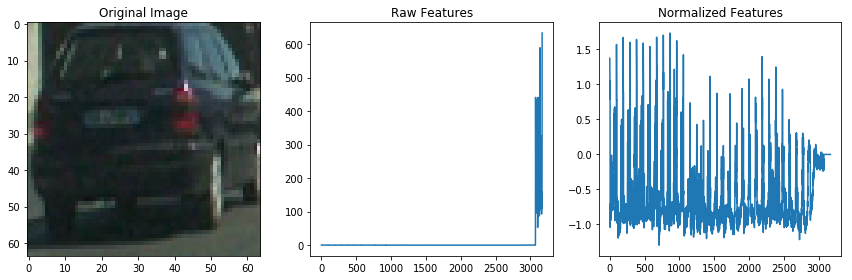

In [18]:
if len(car_features) > 0:
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(CARS_LIST))

    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(CARS_LIST[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
else:
    print('Zero features')

### LinearSVC Color Classify

In [19]:
car_features = extract_features(CARS_LIST)
notcar_features = extract_features(NOT_CARS_LIST)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

41.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9017
My SVC predicts:  [ 1.  0.  0.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
0.00299 Seconds to predict 10 labels with SVC


### LinearSVC HOG Classify

In [20]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        hog_features = get_hog_features(img, orient=9, pix_per_cell=4, cell_per_block=2, vis=False)
        features.append(hog_features)
    return features


sample_size = 500
cars = CARS_LIST[0:sample_size]
notcars = NOT_CARS_LIST[0:sample_size]

colorspace = 'RGB'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

3.8 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8100
11.13 Seconds to train SVC...
Test Accuracy of SVC =  0.505
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  0.  0.  1.  1.]
0.00269 Seconds to predict 10 labels with SVC


### LinearSVC HOG/Color Histogram/Spatial Binning Classify

In [21]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        feature_image = np.copy(image)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)
        _, spatial_features = bin_spatial(feature_image, size=spatial_size)
        _, _, _, _, hist_features = color_histogram(feature_image, bins=hist_bins, bins_range=hist_range)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return features


sample_size = 500
cars = CARS_LIST[0:sample_size]
notcars = NOT_CARS_LIST[0:sample_size]

colorspace = 'RGB'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

config = {}
config["svc"] = svc
config["colorspace"] = colorspace
config["X_scaler"] = X_scaler
config["orient"] = orient
config["pix_per_cell"] = pix_per_cell
config["cell_per_block"] = cell_per_block
config["hog_channel"] = hog_channel

with open('config.p', 'wb') as handle:
    pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)


4.6 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
0.31 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
0.00189 Seconds to predict 10 labels with SVC


### Sliding Window

In [22]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

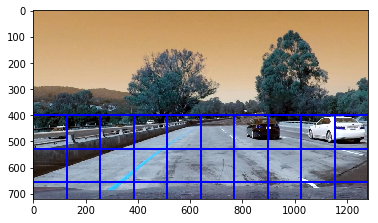

In [23]:
windows = slide_window(TEST_IMAGE, x_start_stop=[None, None], y_start_stop=[400, TEST_IMAGE.shape[1]], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(TEST_IMAGE, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

### Find Cars

In [35]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2

    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    b_boxes = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            _, spatial_features = bin_spatial(subimg, size=(32, 32))
            _, _, _, _, hist_features = color_histogram(subimg, bins=hist_bins)
        
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                b_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return b_boxes
    
ystart = 400
ystop = 656
scale = 1.5
spatial_size = (32, 32), 
hist_bins=32

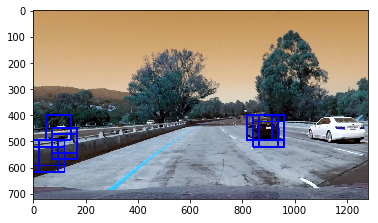

In [36]:
img = cv2.imread('./test_images/test1.jpg')
boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(draw_boxes(img, boxes))
plt.show()

### Add Heat Map

In [37]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img
    

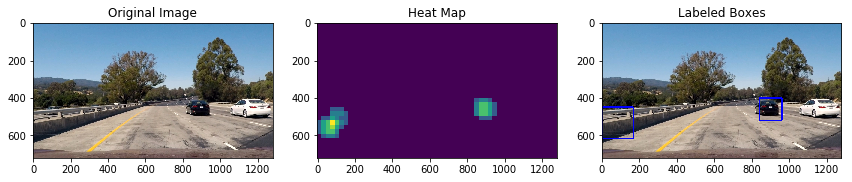

In [41]:
img = mpimg.imread('./test_images/test1.jpg')

boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat, boxes)           
heat = apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(heatmap)
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(draw_img)
plt.title('Labeled Boxes')
fig.tight_layout()
plt.show()